# 4. Exporting Models to ONNX and Running Inference

This notebook demonstrates how to export the trained/optimized PyTorch models to the ONNX (Open Neural Network Exchange) format. It also shows how to run inference using ONNX Runtime on the exported models.

We will export three specific model versions:
1.  **Baseline FP32 Model**: The original MobileNetV2 model adapted for CIFAR-10.
3.  **Baseline QAT INT8 Model**: The baseline model quantized to INT8 using Quantization-Aware Training.

In [1]:
import os
import torch
import onnxruntime as ort

from nnopt.model.export import export_model_to_onnx
from nnopt.recipes.mobilenetv2_cifar10 import load_mobilenetv2_cifar10_model, get_cifar10_datasets
from nnopt.model.const import BASE_MODEL_DIR, DEVICE
from nnopt.model.eval import eval_onnx_model
from nnopt.model.analysis import plot_model_performance_scatter

# Ensure the logger in export is configured (if not already by its import)
import logging
logger = logging.getLogger("nnopt.model.export")
if not logger.hasHandlers():
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                        handlers=[logging.StreamHandler()])

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")
print(f"Using device: {DEVICE}")

/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
2025-06-13 17:53:22,764 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Using device: cuda, dtype: torch.bfloat16


PyTorch version: 2.7.1+cu126
ONNX Runtime version: 1.22.0
Using device: cuda


## Configuration and Dummy Input

In [2]:
# Define model versions to be exported
baseline_fp32_version = "mobilenetv2_cifar10/fp32/baseline"
baseline_qat_int8_version = "mobilenetv2_cifar10/int8/qat_baseline"
struct_pruned_fp32_version = "mobilenetv2_cifar10/fp32/l1_struct_prune_0.3"
unstruct_pruned_fp32_version = "mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7"
unstruct_pruned_qat_int8_version = "mobilenetv2_cifar10/int8/qat_l1_unstruct_prune_0.7"


# Directory to save ONNX models
ONNX_EXPORT_DIR = os.path.join(BASE_MODEL_DIR, "onnx_exports")
os.makedirs(ONNX_EXPORT_DIR, exist_ok=True)
print(f"ONNX models will be saved in: {ONNX_EXPORT_DIR}")

# Create a dummy input tensor (batch_size, channels, height, width)
# MobileNetV2 typically expects 224x224 images.
# CIFAR-10 images are 32x32, but the model adapts them or uses a standard input size.
# Using 224x224 as per common MobileNetV2 usage and example in pruning notebook.
dummy_input_shape = (1, 3, 224, 224)
dummy_input = torch.randn(dummy_input_shape, device='cpu') # ONNX export prefers CPU dummy input
print(f"Dummy input shape: {dummy_input.shape}")

# Define dynamic axes for batch size flexibility
dynamic_axes = {'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}

ONNX models will be saved in: /home/pbeuran/repos/nnopt/models/onnx_exports
Dummy input shape: torch.Size([1, 3, 224, 224])


In [3]:
# Load CIFAR-10 test dataset
# Assuming the data is already downloaded and preprocessed as in other notebooks
# Adjust data_dir if your CIFAR-10 data is located elsewhere
DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'image', 'cifar10') 
_, _, test_dataset = get_cifar10_datasets() # We only need test_dataset

2025-06-13 17:53:22,981 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading existing training and validation datasets...
2025-06-13 17:53:24,639 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading existing test dataset...


## 1. Baseline FP32 Model Export & Inference

In [4]:
# Load the baseline FP32 model
print(f"Loading baseline FP32 model from version: {baseline_fp32_version}")
baseline_fp32_model, baseline_fp32_metadata = load_mobilenetv2_cifar10_model(
    version=baseline_fp32_version,
    device="cpu",  # Use CPU for ONNX export
    mode="jit_trace"
)
baseline_fp32_model.eval()

# Define ONNX path
onnx_path_baseline_fp32 = os.path.join(ONNX_EXPORT_DIR, "mobilenetv2_cifar10_baseline_fp32.onnx")

# Export to ONNX
print(f"Exporting baseline FP32 model to {onnx_path_baseline_fp32}...")
success_fp32 = export_model_to_onnx(
    model=baseline_fp32_model,
    dummy_input=dummy_input,
    onnx_path=onnx_path_baseline_fp32,
    dynamic_axes=dynamic_axes,
    opset_version=13
)

if success_fp32:
    print("Baseline FP32 model exported successfully.")
    # Run inference with ONNX Runtime
    try:
        ort_session_fp32 = ort.InferenceSession(onnx_path_baseline_fp32, providers=['CPUExecutionProvider'])
        input_name_fp32 = ort_session_fp32.get_inputs()[0].name
        output_name_fp32 = ort_session_fp32.get_outputs()[0].name
        
        ort_inputs_fp32 = {input_name_fp32: dummy_input.cpu().numpy()}
        ort_outputs_fp32 = ort_session_fp32.run([output_name_fp32], ort_inputs_fp32)
        print(f"ONNX Runtime (FP32 Baseline) output shape: {ort_outputs_fp32[0].shape}")
    except Exception as e:
        print(f"Error running ONNX Runtime for FP32 baseline model: {e}")
    print("\n--- Evaluating Baseline FP32 ONNX Model on CPU ---")
    baseline_fp32_metrics = eval_onnx_model(
        onnx_model_path=onnx_path_baseline_fp32,
        test_dataset=test_dataset,
        batch_size=32, # Adjust as needed
        device="cpu",
        num_warmup_batches=2 # Smaller warmup for quicker testing
    )
    print(f"CPU ONNX Metrics: {baseline_fp32_metrics}")
else:
    print("Baseline FP32 model export failed.")

2025-06-13 17:53:32,837 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 17:53:32,839 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.9254, 'avg_loss': 0.21455251355171204, 'samples_per_second': 9594.238581494608, 'avg_time_per_batch': 0.006596786050597328, 'avg_time_per_sample': 0.00010422921959943779, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9288, 'avg_loss': 0.20640371625423432, 'samples_per_second': 9116.575566348814, 'avg_time_per_batch': 0.006986643948966146, 'avg_time_per_sample': 0.00010969030999876849, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 

Loading baseline FP32 model from version: mobilenetv2_cifar10/fp32/baseline
Exporting baseline FP32 model to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_fp32.onnx...


/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:814: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7aa7342f9110>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
2025-06-13 17:53:33,222 - nnopt.model.export - INFO - Model successfully exported to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_fp32.onnx
2025-06-13 17:53:33,247 - nnopt.model.eval - INFO - Starting ONNX model evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_fp32.onnx
2025-06-13 17:53:33,250 - nnopt.model.eval - INFO - Evaluation on PyTorch device: cpu, batch size: 32
2025-06-13 17:53:33,251 - nnopt.model.eval - INFO - Using ONNX Runtime providers: ['CPUExecutionProvider']
2025-06-13 17:53:33,267 - nnopt.model.eval - INFO - ONNX Model Input Name: input, Output Name: output
2025-06-13 17:53:33,271 - nnopt.model.eval - INFO - Starting warm

Baseline FP32 model exported successfully.
ONNX Runtime (FP32 Baseline) output shape: (1, 10)

--- Evaluating Baseline FP32 ONNX Model on CPU ---


[ONNX Warmup]: 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]
2025-06-13 17:53:34,060 - nnopt.model.eval - INFO - Warmup complete.
2025-06-13 17:53:34,061 - nnopt.model.eval - INFO - Starting ONNX model evaluation pass...
[ONNX Evaluation]: 100%|██████████| 313/313 [00:32<00:00,  9.78it/s]

ONNX Evaluation Complete: Avg Loss: 0.2091, Accuracy: 0.9279
Throughput: 396.99 samples/sec | Avg Batch Time: 80.48 ms | Avg Sample Time: 2.52 ms
System Stats (PyTorch side): CPU Usage: 68.80% | RAM Usage: 9.3/30.9GB (38.9%)
CPU ONNX Metrics: {'accuracy': 0.9279, 'avg_loss': 0.20908062656521798, 'samples_per_second': 396.98972002341884, 'avg_time_per_batch': 0.08047785667410401, 'avg_time_per_sample': 0.002518956913899456}


## 2. Baseline QAT INT8 Model Export & Inference

In [5]:
# Load the baseline QAT INT8 model
print(f"Loading baseline QAT INT8 model from version: {baseline_qat_int8_version}")
baseline_qat_int8_model, baseline_qat_int8_metadata = load_mobilenetv2_cifar10_model(
    version=baseline_qat_int8_version,
    device="cpu",  # Use CPU for ONNX export
    mode="jit_trace"
)
baseline_qat_int8_model.eval()

# Define ONNX path
onnx_path_baseline_qat_int8 = os.path.join(ONNX_EXPORT_DIR, "mobilenetv2_cifar10_baseline_qat_int8.onnx")

# Export to ONNX
print(f"Exporting baseline QAT INT8 model to {onnx_path_baseline_qat_int8}...")
success_qat_int8 = export_model_to_onnx(
    model=baseline_qat_int8_model,
    dummy_input=dummy_input,
    onnx_path=onnx_path_baseline_qat_int8,
    dynamic_axes=dynamic_axes,
    opset_version=13
)

if success_qat_int8:
    print("Baseline QAT INT8 model exported successfully.")
    # Run inference with ONNX Runtime
    try:
        ort_session_qat_int8 = ort.InferenceSession(onnx_path_baseline_qat_int8, providers=['CPUExecutionProvider'])
        input_name_qat_int8 = ort_session_qat_int8.get_inputs()[0].name
        output_name_qat_int8 = ort_session_qat_int8.get_outputs()[0].name

        ort_inputs_qat_int8 = {input_name_qat_int8: dummy_input.cpu().numpy()}
        ort_outputs_qat_int8 = ort_session_qat_int8.run([output_name_qat_int8], ort_inputs_qat_int8)
        print(f"ONNX Runtime (QAT INT8 Baseline) output shape: {ort_outputs_qat_int8[0].shape}")
    except Exception as e:
        print(f"Error running ONNX Runtime for QAT INT8 baseline model: {e}")
    print("\n--- Evaluating Baseline QAT INT8 ONNX Model on CPU ---")
    baseline_qat_int8_metrics = eval_onnx_model(
        onnx_model_path=onnx_path_baseline_qat_int8,
        test_dataset=test_dataset,
        batch_size=32, # Adjust as needed
        device="cpu",
        num_warmup_batches=2 # Smaller warmup for quicker testing
    )
    print(f"CPU ONNX Metrics: {baseline_qat_int8_metrics}")
else:
    print("Baseline FP32 model export failed.")

2025-06-13 17:54:06,157 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/int8/qat_baseline at /home/pbeuran/repos/nnopt/models
2025-06-13 17:54:06,158 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'accuracy': 0.863, 'avg_loss': 0.41772424149513243, 'samples_per_second': 255.84980960873506, 'avg_time_per_batch': 0.1244758939108254, 'avg_time_per_sample': 0.003908543068799918, 'params_stats': {'int_weight_params': 2202560, 'float_weight_params': 0, 'float_bias_params': 17066, 'bn_param_params': 0, 'other_float_params': 0, 'total_params': 2219626, 'approx_memory_mb_for_params': 2.1656265258789062}}}
2025-06-13 17:54:06,159 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading JIT traced model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/qat_baseline/jit_trace.pt


Loading baseline QAT INT8 model from version: mobilenetv2_cifar10/int8/qat_baseline


2025-06-13 17:54:06,326 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded JIT traced model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/qat_baseline/jit_trace.pt
2025-06-13 17:54:06,327 - nnopt.model.export - INFO - Starting ONNX export to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_qat_int8.onnx with opset_version=13...


Exporting baseline QAT INT8 model to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_qat_int8.onnx...


/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:814: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7aa7342f9110>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/torch/jit/_trace.py:685: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(
2025-06-13 17:54:06,757 - nnopt.model.export - INFO - Model successfully exported to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_qat_int8.onnx
2025-06-13 17:54:06,795 - nnopt.model.eval - INFO - Starting ONNX model evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_baseline_qat_int8.onnx
2025-06-13 17:54:06,795 - nnopt.model.eval - INFO - Evaluation on PyTorch device: cpu, batch size: 32
2025-06-13 17:54:06,796 - nnopt.model.eval - INFO - U

Baseline QAT INT8 model exported successfully.
ONNX Runtime (QAT INT8 Baseline) output shape: (1, 10)

--- Evaluating Baseline QAT INT8 ONNX Model on CPU ---


[ONNX Warmup]: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s]
2025-06-13 17:54:07,193 - nnopt.model.eval - INFO - Warmup complete.
2025-06-13 17:54:07,193 - nnopt.model.eval - INFO - Starting ONNX model evaluation pass...
[ONNX Evaluation]: 100%|██████████| 313/313 [00:18<00:00, 16.68it/s]

ONNX Evaluation Complete: Avg Loss: 0.4172, Accuracy: 0.8594
Throughput: 804.80 samples/sec | Avg Batch Time: 39.70 ms | Avg Sample Time: 1.24 ms
System Stats (PyTorch side): CPU Usage: 93.30% | RAM Usage: 9.0/30.9GB (37.9%)
CPU ONNX Metrics: {'accuracy': 0.8594, 'avg_loss': 0.4171901930809021, 'samples_per_second': 804.7954925353717, 'avg_time_per_batch': 0.03969813708633959, 'avg_time_per_sample': 0.0012425516908024293}


## 3. L1-structured Pruning FP32 Model Export & Inference

In [19]:
# Load the structured pruned FP32 model
print(f"Loading structured pruned FP32 model from version: {struct_pruned_fp32_version}")
struct_pruned_fp32_model, struct_pruned_fp32_metadata = load_mobilenetv2_cifar10_model(
    version=struct_pruned_fp32_version,
    device="cpu",  # Use CPU for ONNX export
    mode="jit_trace"
)
struct_pruned_fp32_model.eval()

# Define ONNX path
onnx_path_pruned_fp32 = os.path.join(ONNX_EXPORT_DIR, "mobilenetv2_cifar10_pruned_fp32.onnx")

# Export to ONNX
print(f"Exporting structured pruned FP32 model to {onnx_path_pruned_fp32}...")
success_fp32 = export_model_to_onnx(
    model=struct_pruned_fp32_model,
    dummy_input=dummy_input,
    onnx_path=onnx_path_pruned_fp32,
    dynamic_axes=dynamic_axes,
    opset_version=13
)

if success_fp32:
    print("Structured pruned FP32 model exported successfully.")
    # Run inference with ONNX Runtime
    try:
        ort_session_fp32 = ort.InferenceSession(onnx_path_pruned_fp32, providers=['CPUExecutionProvider'])
        input_name_fp32 = ort_session_fp32.get_inputs()[0].name
        output_name_fp32 = ort_session_fp32.get_outputs()[0].name
        
        ort_inputs_fp32 = {input_name_fp32: dummy_input.cpu().numpy()}
        ort_outputs_fp32 = ort_session_fp32.run([output_name_fp32], ort_inputs_fp32)
        print(f"ONNX Runtime (FP32 Structured Pruned) output shape: {ort_outputs_fp32[0].shape}")
    except Exception as e:
        print(f"Error running ONNX Runtime for FP32 structured pruned model: {e}")
    print("\n--- Evaluating Structured Pruned FP32 ONNX Model on CPU ---")
    structured_pruned_fp32_metrics = eval_onnx_model(
        onnx_model_path=onnx_path_pruned_fp32,
        test_dataset=test_dataset,
        batch_size=32, # Adjust as needed
        device="cpu",
        num_warmup_batches=2 # Smaller warmup for quicker testing
    )
    print(f"CPU ONNX Metrics: {structured_pruned_fp32_metrics}")
else:
    print("Structured Pruned FP32 model export failed.")

2025-06-13 17:58:56,557 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/l1_struct_prune_0.3 at /home/pbeuran/repos/nnopt/models
2025-06-13 17:58:56,558 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.7892, 'avg_loss': 0.6139473709106446, 'samples_per_second': 9049.953083963761, 'avg_time_per_batch': 0.006993532303792413, 'avg_time_per_sample': 0.00011049781039992013, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 584051, 'float_bias_params': 10, 'bn_param_params': 17100, 'other_float_params': 0, 'total_params': 601161, 'approx_memory_mb_for_params': 2.2932472229003906}}, 'test_metrics': {'accuracy': 0.7872, 'avg_loss': 0.6139407681465149, 'samples_per_second': 10497.233072640314, 'avg_time_per_batch': 0.006067719662425565, 'avg_time_per_sample': 9.526319870008137e-05, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 5

Loading structured pruned FP32 model from version: mobilenetv2_cifar10/fp32/l1_struct_prune_0.3
Exporting structured pruned FP32 model to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_pruned_fp32.onnx...


/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:814: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7aa7342f9110>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
2025-06-13 17:58:56,841 - nnopt.model.export - INFO - Model successfully exported to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_pruned_fp32.onnx
2025-06-13 17:58:56,883 - nnopt.model.eval - INFO - Starting ONNX model evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_pruned_fp32.onnx
2025-06-13 17:58:56,884 - nnopt.model.eval - INFO - Evaluation on PyTorch device: cpu, batch size: 32
2025-06-13 17:58:56,885 - nnopt.model.eval - INFO - Using ONNX Runtime providers: ['CPUExecutionProvider']
2025-06-13 17:58:56,904 - nnopt.model.eval - INFO - ONNX Model Input Name: input, Output Name: output
2025-06-13 17:58:56,905 - nnopt.model.eval - INFO - Starting warmup f

Structured pruned FP32 model exported successfully.
ONNX Runtime (FP32 Structured Pruned) output shape: (1, 10)

--- Evaluating Structured Pruned FP32 ONNX Model on CPU ---


[ONNX Warmup]: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]
2025-06-13 17:58:57,614 - nnopt.model.eval - INFO - Warmup complete.
2025-06-13 17:58:57,615 - nnopt.model.eval - INFO - Starting ONNX model evaluation pass...
[ONNX Evaluation]: 100%|██████████| 313/313 [01:06<00:00,  4.74it/s]

ONNX Evaluation Complete: Avg Loss: 0.6140, Accuracy: 0.7871
Throughput: 167.02 samples/sec | Avg Batch Time: 191.29 ms | Avg Sample Time: 5.99 ms
System Stats (PyTorch side): CPU Usage: 33.70% | RAM Usage: 9.3/30.9GB (38.8%)
CPU ONNX Metrics: {'accuracy': 0.7871, 'avg_loss': 0.61395387840271, 'samples_per_second': 167.01678243352802, 'avg_time_per_batch': 0.19129144582732518, 'avg_time_per_sample': 0.005987422254395278}


# 4. L1-unstructured Pruning FP32 Model Export & Inference

In [7]:
# Load the unstructured pruned FP32 model
print(f"Loading unstructured pruned FP32 model from version: {unstruct_pruned_fp32_version}")
unstruct_pruned_fp32_model, unstructured_pruned_fp32_metadata = load_mobilenetv2_cifar10_model(
    version=unstruct_pruned_fp32_version,
    device="cpu",  # Use CPU for ONNX export
    mode="jit_trace"
)
unstruct_pruned_fp32_model.eval()

# Define ONNX path
onnx_path_unstruct_fp32 = os.path.join(ONNX_EXPORT_DIR, "mobilenetv2_cifar10_unstructured_pruned_fp32.onnx")

# Export to ONNX
print(f"Exporting unstructured pruned FP32 model to {onnx_path_unstruct_fp32}...")
success_fp32 = export_model_to_onnx(
    model=unstruct_pruned_fp32_model,
    dummy_input=dummy_input,
    onnx_path=onnx_path_unstruct_fp32,
    dynamic_axes=dynamic_axes,
    opset_version=13
)

if success_fp32:
    print("Unstructured pruned FP32 model exported successfully.")
    # Run inference with ONNX Runtime
    try:
        ort_session_fp32 = ort.InferenceSession(onnx_path_unstruct_fp32, providers=['CPUExecutionProvider'])
        input_name_fp32 = ort_session_fp32.get_inputs()[0].name
        output_name_fp32 = ort_session_fp32.get_outputs()[0].name
        
        ort_inputs_fp32 = {input_name_fp32: dummy_input.cpu().numpy()}
        ort_outputs_fp32 = ort_session_fp32.run([output_name_fp32], ort_inputs_fp32)
        print(f"ONNX Runtime (FP32 Unstructured Pruned) output shape: {ort_outputs_fp32[0].shape}")
    except Exception as e:
        print(f"Error running ONNX Runtime for FP32 unstructured pruned model: {e}")
    print("\n--- Evaluating Unstructured Pruned FP32 ONNX Model on CPU ---")
    unstructured_pruned_fp32_metrics = eval_onnx_model(
        onnx_model_path=onnx_path_unstruct_fp32,
        test_dataset=test_dataset,
        batch_size=32, # Adjust as needed
        device="cpu",
        num_warmup_batches=2 # Smaller warmup for quicker testing
    )
    print(f"CPU ONNX Metrics: {unstructured_pruned_fp32_metrics}")
else:
    print("Unstructured Pruned FP32 model export failed.")

2025-06-13 17:55:34,123 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7 at /home/pbeuran/repos/nnopt/models
2025-06-13 17:55:34,124 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'unstructured_sparse_config': {'pruning_amount': 0.7}, 'metrics_values': {'val_metrics': {'accuracy': 0.871, 'avg_loss': 0.3521343002319336, 'samples_per_second': 8535.882614956985, 'avg_time_per_batch': 0.007414715278488546, 'avg_time_per_sample': 0.00011715250140011903, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.8729, 'avg_loss': 0.3661128273010254, 'samples_per_second': 8581.675884406815, 'avg_time_per_batch': 0.007422124579612489, 'avg_time_per_sample': 0.00011652735589991607, 'params_

Loading unstructured pruned FP32 model from version: mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7
Exporting unstructured pruned FP32 model to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_fp32.onnx...


2025-06-13 17:55:34,459 - nnopt.model.export - INFO - Model successfully exported to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_fp32.onnx
2025-06-13 17:55:34,488 - nnopt.model.eval - INFO - Starting ONNX model evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_fp32.onnx
2025-06-13 17:55:34,489 - nnopt.model.eval - INFO - Evaluation on PyTorch device: cpu, batch size: 32
2025-06-13 17:55:34,489 - nnopt.model.eval - INFO - Using ONNX Runtime providers: ['CPUExecutionProvider']
2025-06-13 17:55:34,515 - nnopt.model.eval - INFO - ONNX Model Input Name: input, Output Name: output
2025-06-13 17:55:34,517 - nnopt.model.eval - INFO - Starting warmup for 2 batches...


Unstructured pruned FP32 model exported successfully.
ONNX Runtime (FP32 Unstructured Pruned) output shape: (1, 10)

--- Evaluating Unstructured Pruned FP32 ONNX Model on CPU ---


[ONNX Warmup]: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]
2025-06-13 17:55:34,970 - nnopt.model.eval - INFO - Warmup complete.
2025-06-13 17:55:34,970 - nnopt.model.eval - INFO - Starting ONNX model evaluation pass...
[ONNX Evaluation]: 100%|██████████| 313/313 [00:30<00:00, 10.20it/s]

ONNX Evaluation Complete: Avg Loss: 0.3660, Accuracy: 0.8718
Throughput: 411.31 samples/sec | Avg Batch Time: 77.68 ms | Avg Sample Time: 2.43 ms
System Stats (PyTorch side): CPU Usage: 96.70% | RAM Usage: 9.3/30.9GB (38.9%)
CPU ONNX Metrics: {'accuracy': 0.8718, 'avg_loss': 0.36604598178863523, 'samples_per_second': 411.3089704819401, 'avg_time_per_batch': 0.07767611231941318, 'avg_time_per_sample': 0.0024312623155976327}


# 5. L1-unstructured Pruning QAT INT8 Model Export & Inference

In [8]:
# Load the unstructured pruned QAT INT8 model
print(f"Loading unstructured pruned QAT INT8 model from version: {unstruct_pruned_qat_int8_version}")
unstruct_pruned_qat_int8_model, unstructured_pruned_qat_int8_metadata = load_mobilenetv2_cifar10_model(
    version=unstruct_pruned_qat_int8_version,
    device="cpu",  # Use CPU for ONNX export
    mode="jit_trace"
)
unstruct_pruned_qat_int8_model.eval()

# Define ONNX path
onnx_path_unstruct_qat_int8 = os.path.join(ONNX_EXPORT_DIR, "mobilenetv2_cifar10_unstructured_pruned_qat_int8.onnx")

# Export to ONNX
print(f"Exporting unstructured pruned QAT INT8 model to {onnx_path_unstruct_qat_int8}...")
success_qat_int8 = export_model_to_onnx(
    model=unstruct_pruned_qat_int8_model,
    dummy_input=dummy_input,
    onnx_path=onnx_path_unstruct_qat_int8,
    dynamic_axes=dynamic_axes,
    opset_version=13
)

if success_qat_int8:
    print("Unstructured pruned QAT INT8 model exported successfully.")
    # Run inference with ONNX Runtime
    try:
        ort_session_qat_int8 = ort.InferenceSession(onnx_path_unstruct_qat_int8, providers=['CPUExecutionProvider'])
        input_name_qat_int8 = ort_session_qat_int8.get_inputs()[0].name
        output_name_qat_int8 = ort_session_qat_int8.get_outputs()[0].name

        ort_inputs_qat_int8 = {input_name_qat_int8: dummy_input.cpu().numpy()}
        ort_outputs_qat_int8 = ort_session_qat_int8.run([output_name_qat_int8], ort_inputs_qat_int8)
        print(f"ONNX Runtime (QAT INT8 Unstructured Pruned) output shape: {ort_outputs_qat_int8[0].shape}")
    except Exception as e:
        print(f"Error running ONNX Runtime for QAT INT8 unstructured pruned model: {e}")
    print("\n--- Evaluating Unstructured Pruned QAT INT8 ONNX Model on CPU ---")
    unstructured_pruned_qat_int8_metrics = eval_onnx_model(
        onnx_model_path=onnx_path_unstruct_qat_int8,
        test_dataset=test_dataset,
        batch_size=32, # Adjust as needed
        device="cpu",
        num_warmup_batches=2 # Smaller warmup for quicker testing
    )
    print(f"CPU ONNX Metrics: {unstructured_pruned_qat_int8_metrics}")
else:
    print("Unstructured Pruned QAT INT8 model export failed.")

2025-06-13 17:56:05,720 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 from version: mobilenetv2_cifar10/int8/qat_l1_unstruct_prune_0.7 at /home/pbeuran/repos/nnopt/models
2025-06-13 17:56:05,722 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'accuracy': 0.852, 'avg_loss': 0.4459613035678864, 'samples_per_second': 657.254791807145, 'avg_time_per_batch': 0.04845477607001841, 'avg_time_per_sample': 0.0015214799685985781, 'params_stats': {'int_weight_params': 2202560, 'float_weight_params': 0, 'float_bias_params': 17066, 'bn_param_params': 0, 'other_float_params': 0, 'total_params': 2219626, 'approx_memory_mb_for_params': 2.1656265258789062}}}
2025-06-13 17:56:05,723 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading JIT traced model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/qat_l1_unstruct_prune_0.7/jit_trace.pt


Loading unstructured pruned QAT INT8 model from version: mobilenetv2_cifar10/int8/qat_l1_unstruct_prune_0.7


2025-06-13 17:56:05,896 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded JIT traced model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/int8/qat_l1_unstruct_prune_0.7/jit_trace.pt
2025-06-13 17:56:05,897 - nnopt.model.export - INFO - Starting ONNX export to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_qat_int8.onnx with opset_version=13...


Exporting unstructured pruned QAT INT8 model to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_qat_int8.onnx...


/home/pbeuran/repos/nnopt/.venv/lib/python3.12/site-packages/torch/jit/_trace.py:685: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(
2025-06-13 17:56:06,333 - nnopt.model.export - INFO - Model successfully exported to /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_qat_int8.onnx
2025-06-13 17:56:06,377 - nnopt.model.eval - INFO - Starting ONNX model evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_qat_int8.onnx
2025-06-13 17:56:06,378 - nnopt.model.eval - INFO - Evaluation on PyTorch device: cpu, batch size: 32
2025-06-13 17:56:06,378 - nnopt.model.eval - INFO - Using ONNX Runtime providers: ['CPUExecutionProvider']
2025-06-13 17:56:06,423 - nnopt.model.eval - INFO - ONNX Model Input Name: input, Output Name: output
2025-06-13 17:56:06,423 - nnopt.model.eval - INFO - Starting warmup for 2 batches...


Unstructured pruned QAT INT8 model exported successfully.
ONNX Runtime (QAT INT8 Unstructured Pruned) output shape: (1, 10)

--- Evaluating Unstructured Pruned QAT INT8 ONNX Model on CPU ---


[ONNX Warmup]: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]
2025-06-13 17:56:06,785 - nnopt.model.eval - INFO - Warmup complete.
2025-06-13 17:56:06,786 - nnopt.model.eval - INFO - Starting ONNX model evaluation pass...
[ONNX Evaluation]: 100%|██████████| 313/313 [00:18<00:00, 17.15it/s]

ONNX Evaluation Complete: Avg Loss: 0.4254, Accuracy: 0.8575
Throughput: 831.20 samples/sec | Avg Batch Time: 38.44 ms | Avg Sample Time: 1.20 ms
System Stats (PyTorch side): CPU Usage: 93.10% | RAM Usage: 9.1/30.9GB (38.2%)
CPU ONNX Metrics: {'accuracy': 0.8575, 'avg_loss': 0.4253957066774368, 'samples_per_second': 831.1951243276637, 'avg_time_per_batch': 0.03843728247922552, 'avg_time_per_sample': 0.0012030869415997586}


# 6. L1-unstructured Pruning FP32 Model Export & Inference (with OpenVINO)

In [10]:
# --- Evaluating Unstructured L1‐Pruned FP32 Model with OpenVINO Sparse Acceleration (fixed) ---
from tqdm import tqdm
from nnopt.model.eval import eval_model_openvino

print("\n--- Evaluating Unstructured FP32 Model with OpenVINO Sparse Acceleration ---")
ov_metrics = eval_model_openvino(
    onnx_model_path=onnx_path_unstruct_fp32,
    test_dataset=test_dataset,
    batch_size=32,             # match your earlier config
    sparse_rate=0.7,           # set to your actual sparsity threshold
    num_warmup_batches=2,
    num_workers=4,
    pin_memory=True
)
print(f"OpenVINO Sparse Metrics: {ov_metrics}")


--- Evaluating Unstructured FP32 Model with OpenVINO Sparse Acceleration ---
Starting OpenVINO evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_fp32.onnx


[OpenVINO Evaluation]: 100%|██████████| 313/313 [00:08<00:00, 35.53it/s]

OpenVINO Evaluation Complete: Avg Loss: 0.3647, Accuracy: 0.8737
Throughput: 1244.38 samples/sec | Avg Batch Time: 25.67 ms | Avg Sample Time: 0.80 ms
System Stats: CPU Usage: 32.30% | RAM Usage: 9.2/30.9GB (38.4%)
OpenVINO Sparse Metrics: {'accuracy': 0.8737, 'avg_loss': 0.3647082891941071, 'samples_per_second': 1244.3773030844434, 'avg_time_per_batch': 0.025674593798798443, 'avg_time_per_sample': 0.0008036147859023913}


# 7. L1-unstructured Pruning QAT INT8 Model Export & Inference (with OpenVINO)



In [11]:
# --- Evaluating Unstructured L1‐Pruned FP32 Model with OpenVINO Sparse Acceleration (fixed) ---
from tqdm import tqdm
from nnopt.model.eval import eval_model_openvino

print("\n--- Evaluating Unstructured QAT INT8 Model with OpenVINO Sparse Acceleration ---")
ov_metrics = eval_model_openvino(
    onnx_model_path=onnx_path_unstruct_qat_int8,
    test_dataset=test_dataset,
    batch_size=32,             # match your earlier config
    sparse_rate=0.7,           # set to your actual sparsity threshold
    num_warmup_batches=2,
    num_workers=4,
    pin_memory=True
)
print(f"OpenVINO Sparse Metrics: {ov_metrics}")


--- Evaluating Unstructured QAT INT8 Model with OpenVINO Sparse Acceleration ---
Starting OpenVINO evaluation for: /home/pbeuran/repos/nnopt/models/onnx_exports/mobilenetv2_cifar10_unstructured_pruned_qat_int8.onnx


[OpenVINO Evaluation]: 100%|██████████| 313/313 [00:05<00:00, 54.18it/s]


OpenVINO Evaluation Complete: Avg Loss: 0.4230, Accuracy: 0.8575
Throughput: 2013.72 samples/sec | Avg Batch Time: 15.87 ms | Avg Sample Time: 0.50 ms
System Stats: CPU Usage: 63.10% | RAM Usage: 9.1/30.9GB (38.1%)
OpenVINO Sparse Metrics: {'accuracy': 0.8575, 'avg_loss': 0.42298286283016207, 'samples_per_second': 2013.7229435240997, 'avg_time_per_batch': 0.01586557966769028, 'avg_time_per_sample': 0.0004965926435987058}


# Analysis

In [ ]:
model_names = [
    "Baseline FP32",
    "Baseline QAT INT8",
    "Structured Pruned FP32",
    "Unstructured Pruned FP32",
    "Unstructured Pruned QAT INT8"
]

test_accuracies = [
    baseline_fp32_metrics['accuracy'],
    baseline_qat_int8_metrics['accuracy'],
    structured_pruned_fp32_metrics['accuracy'],
    unstructured_pruned_fp32_metrics['accuracy'],
    unstructured_pruned_qat_int8_metrics['accuracy']
]

cpu_time_per_sample = [
    baseline_fp32_metrics['avg_time_per_sample']/1000,
    baseline_qat_int8_metrics['avg_time_per_sample']/1000,
    structured_pruned_fp32_metrics['avg_time_per_sample']/1000,
    unstructured_pruned_fp32_metrics['avg_time_per_sample']/1000,
    unstructured_pruned_qat_int8_metrics['avg_time_per_sample']/1000
]

total_params_mb_fn = lambda metadata, bits, pruning_amount: metadata['params_stats']['total_params'] * bits * (1 - pruning_amount) / 8 / (1024 * 1024)
total_params_mb_test = [
    total_params_mb_fn(baseline_fp32_metadata['metrics_values']['test_metrics'], 32, 0.0),  # Baseline FP32
    total_params_mb_fn(baseline_qat_int8_metadata['metrics_values'], 8, 0.0),  # Baseline QAT INT8
    total_params_mb_fn(struct_pruned_fp32_metadata['metrics_values']['test_metrics'], 32, 0.0),  # Structured Pruned FP32
    total_params_mb_fn(unstructured_pruned_fp32_metadata['metrics_values']['test_metrics'], 32, 0.7),  # Unstructured Pruned FP32
    total_params_mb_fn(unstructured_pruned_qat_int8_metadata['metrics_values'], 8, 0.7)   # Unstructured Pruned QAT INT8
]

model_styles = [
        {'color': 'blue', 'marker': 'o'},  # Baseline FP32
        {'color': 'blue', 'marker': 's'},  # Baseline QAT INT8
        {'color': 'green', 'marker': 'o'},  # Structured Pruned FP32
        {'color': 'red', 'marker': 'o'},  # Unstructured Pruned FP32
        {'color': 'red', 'marker': 's'},  # Unstructured Pruned QAT INT8
]

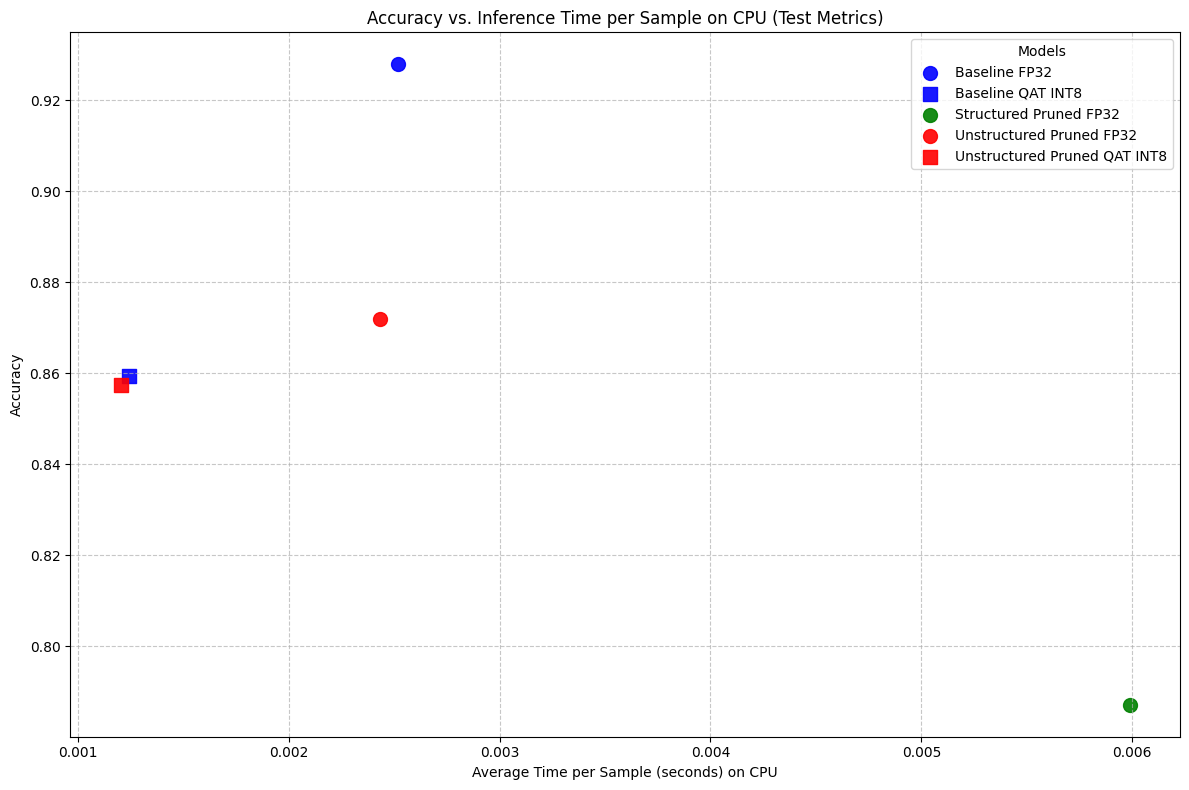

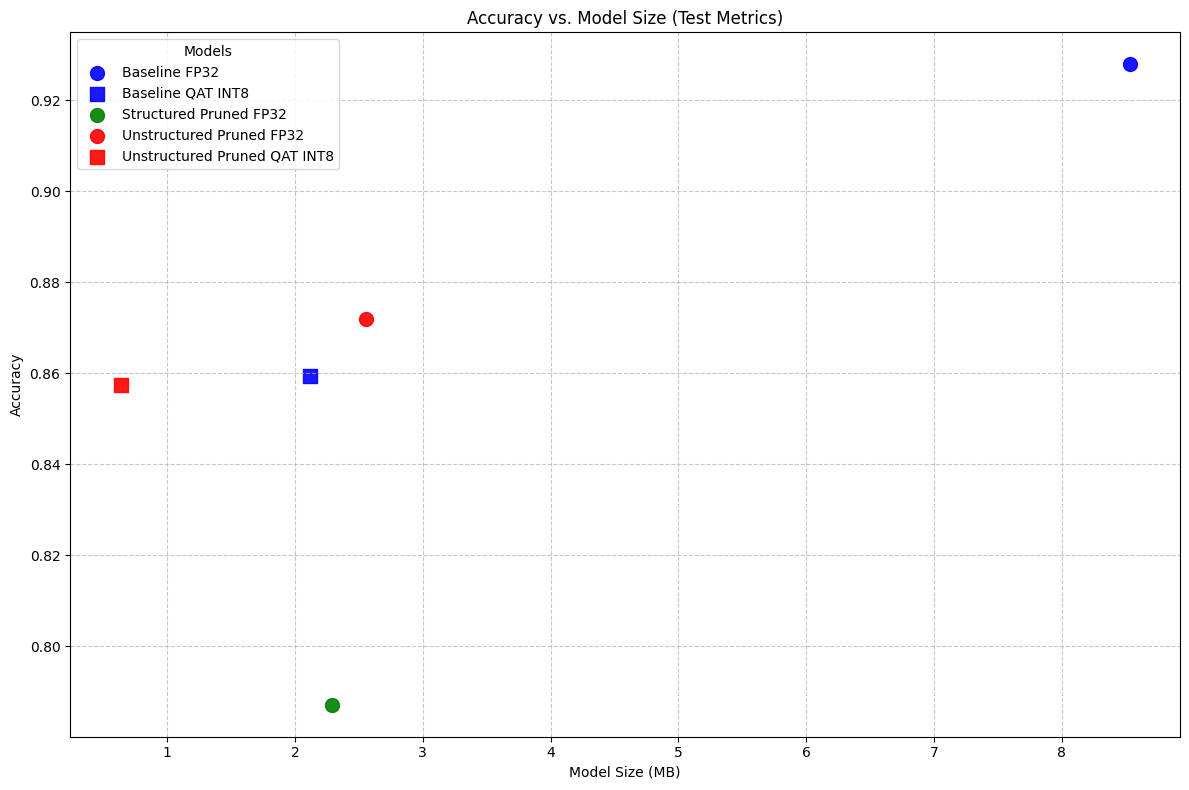

In [25]:
plot_model_performance_scatter(
    model_names=model_names,
    test_accuracies=test_accuracies,
    cpu_time_per_sample_test=cpu_time_per_sample,
    total_params_mb_test=total_params_mb_test,
    model_styles=model_styles
)